In [1]:
import sys
sys.path.append("/home/aunai/build_phare")
sys.path.append("/home/aunai/PHARE/pyphare/")

In [2]:
import os
import numpy as np
import pyphare
from pyphare.pharesee.hierarchy import hierarchy_from
from pyphare.pharesee.plotting import zoom_effect
import matplotlib.pyplot as plt
from pyphare.pharesee.run import Run
from pyphare.pharesee.hierarchy import compute_hier_from
%matplotlib notebook

In [3]:
#some temporary function to get times in h5 file
import h5py
path = "../phare_jobs/tests/functional/alfven_wave/alfven_refine/EM_B.h5"
def get_times(path):
    f = h5py.File(path, "r")
    times=[]
    for k in f.keys():
        times.append(float(k.strip("t")))
    f.close()
    return times

In [4]:
# functions to get the finest value
def finest_level(hierarchy):
    return len(hierarchy.patch_levels)-1

def finest(pdata, ilvl, hierarchy):
    # although a priori doable for particles
    # this just works for fields for now
    
    assert pdata.quantity == 'field'  
    
    lvl = hierarchy.patch_levels[ilvl]
    x_ = pdata.x
    v_ = pdata.dataset
    
    qtyname = pdata.field_name
    inner = x_ != x_
    
    inner[:6] = True
    inner[-5:]= True
    
    if ilvl == finest_level(hierarchy):
        return x_[~inner],v_[~inner]
    
    # iteratively fill the mask with true where current patch coordinates
    # are within limits of the next refined level patchdatas
    for ipatch, finer_patch in enumerate(hierarchy.patch_levels[ilvl+1].patches):
        pdat = finer_patch.patch_datas[qtyname]
        xmin,xmax = [pdat.x[ix] for ix in (4,-4)]
        #inner  = inner | ((x_ > xmin) & (x_ < xmax))
        
    # now take the complement of the mas
    # i.e. data that has coordinates not existing on
    # next finer level
    x = x_[~inner]
    v = v_[~inner]
    
    return x, v

In [5]:
def plot_job(job, time, qty, file_idx=None,**kwargs):
    path = os.path.join(main_jobs_path, job)
    r = Run(path)
    t=time        
    B = r.GetB(t)
    N = r.GetNi(t)
    V = r.GetVi(t)
    if qty in ("Bx","By","Bz"):
        self = B
    if qty == "rho":
        self = N
    if qty in ("Vx", "Vy", "Vz"):
        self = V
    fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
    colors = ["k", "b", "r"]
    for ilvl, lvl in self.patch_levels.items():
        for pidx, patch in enumerate(lvl.patches):
            pdata  = patch.patch_datas[qty]
            x,v = finest(pdata, ilvl, self)
            ax1.plot(x, v,label="lev{} - patch{}".format(ilvl, pidx),
                     marker='o', markersize=2, color=colors[ilvl])

    for ilvl,level in B.patch_levels.items():
        for patch in level.patches:
            dx = patch.dx
            x0 = patch.origin[0]
            x1 = (patch.box.upper[0]+1)*dx
            ax2.axvspan(x0, x1, color='b',ec='k', alpha=0.2,
                        ymin=ilvl/4, ymax=(ilvl+1)/4)

    ax1.set_title("{} at t = {}".format(job,t))

    ax1.set_ylim(kwargs.get("ylim",(-3.5, 3.5)))

    ax1.set_xlim(kwargs.get("xlim", (0,500)))
    if file_idx is not None:
        fig.savefig(path+'/'+job+"_"+qty+"_{:04d}.png".format(file_idx))
        plt.close(fig)
    return fig, ax1, ax2

# Alfven Wave test
 The goal of this test is to propagate an Alfvén wave in a 1D domain with and without fixed mesh refinement. The Ohm's law in these runs is pure electron ideal term (no electron pressure, no dissipation)

In [77]:
# some variable definitions
main_jobs_path = "../phare_jobs/tests/functional/alfven_wave/"

jobs = [
        "alfven_refine",
        "alfven_norefine"
      ]

## 1 level refinement

Here we manually setup the refinement box so that it is refined with one level between x=3 and x=6.3

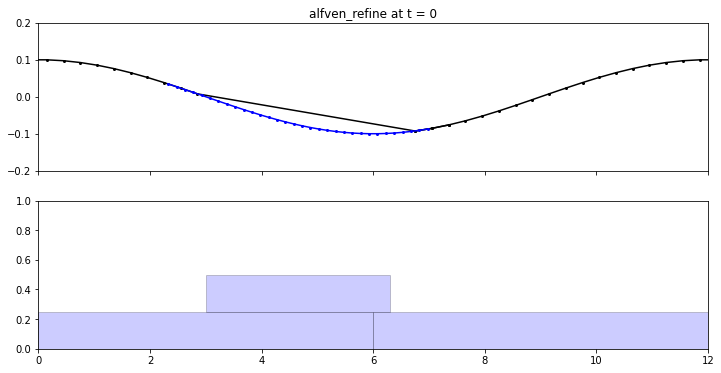

In [85]:
plot_job("alfven_refine", 0, "By", ylim=(-0.2,0.2), xlim=(0,12))

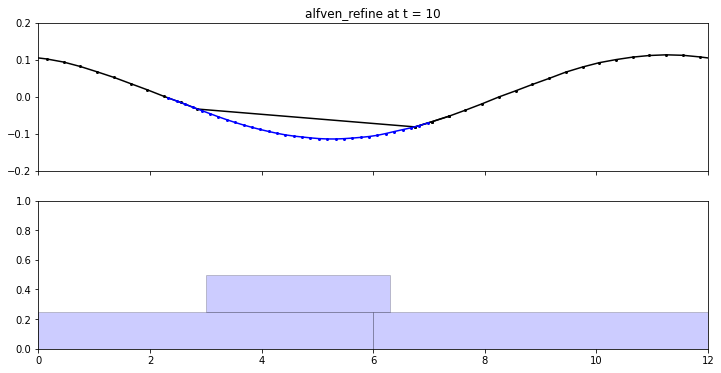

In [82]:
plot_job("alfven_refine", 10, "By", ylim=(-0.2,0.2), xlim=(0,12))

In [113]:
#movie
for it,t in enumerate(get_times(main_jobs_path+"alfven_refine/EM_B.h5")):
    plot_job("alfven_refine", t, "By", it, ylim=(0.8,1.2), xlim=(0,12))

## with no refinement

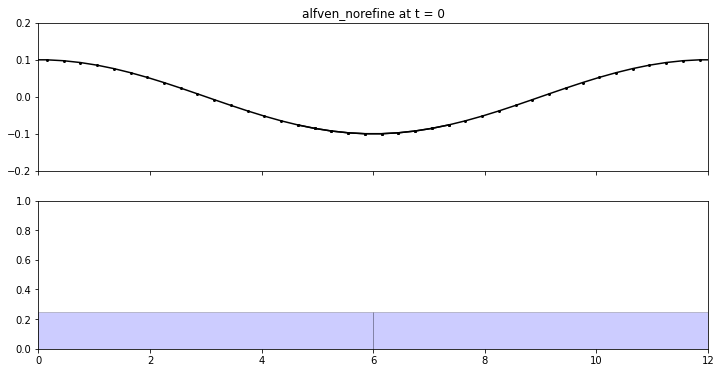

In [86]:
plot_job("alfven_norefine", 0, "By", ylim=(-0.2,0.2), xlim=(0,12))

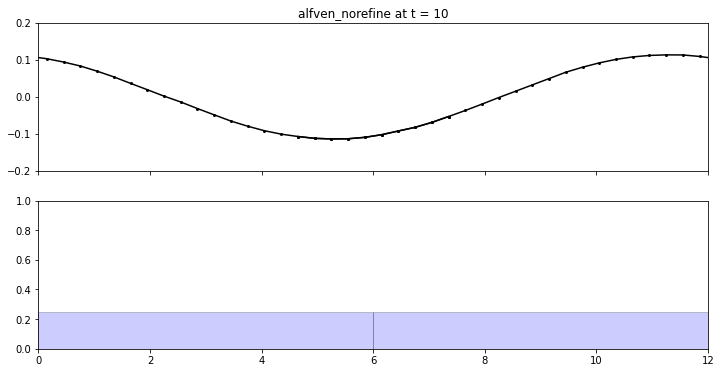

In [87]:
plot_job("alfven_norefine", 10, "By", ylim=(-0.2,0.2), xlim=(0,12))

In [114]:
#movie
for it,t in enumerate(get_times(main_jobs_path+"alfven_refine/EM_B.h5")):
    plot_job("alfven_norefine", t, "By", it, ylim=(-0.2,0.2), xlim=(0,12))

# Translation test

This goal of this section is to investigate results of PHARE ran in a fixed refinement when there is transport across the level boundaries.

In [14]:
# some variable definitions
main_jobs_path = "../phare_jobs/tests/functional/translation/"

jobs = [
        #"uni_vx0p5",           # uniform plasma Vx = 0.5 with hyperres
        #"uni_vx1",             # uniform plasma Vx = 1 with hyperres
        "uni_vx2",             # uniform plasma Vx = 2 with hyperres
        "uni_vxm2",            # uniform plasma with Vx=-2 with hyperres
         "uni_vxm2_nohyperres", # uniform plasma with Vx=-2 without hyperres
    
        "uni_vx2_nohyperres",  # uniform plasma Vx = 2
        "uni_vx2_norefine_nohyperres", #Vx=2, nu=0, no refinement
        "uni_vx2_norefine",     # Vx=2, nu=0.01, 3 refinement levels
        "td_vx2",               # td case with Vx=2 with hyperres
    
        # tangential discontinuity cases with no hypersistivity
        #"td_vx0p5",            # td case with Vx=0.5
        #"td_vx1",
        "td_vx2_nohyperres",    # td case, vx=2, nu=0, 3 refinement levels
        "td_vx2_norefine",      # td case, vx=2, nu=0.01, no refinement
        "td_vx2_norefine_nohyperres" #td case, vx=2, nu=0, no refinement
      ]

## Uniform plasma with drift velocity

In these tests we have: $B_y=1$ and $n=1$


In [13]:
# initialization script
  This function defines the Simulation object,
    user initialization model and diagnostics.

    Simulation(
        smallest_patch_size=20,
        largest_patch_size=20,
        time_step_nbr=2000,        # number of time steps (not specified if time_step and final_time provided)
        final_time=20.,             # simulation final time (not specified if time_step and time_step_nbr provided)
        boundary_types="periodic", # boundary condition, string or tuple, length == len(cell) == len(dl)
        cells=500,                # integer or tuple length == dimension
        dl=1,                  # mesh size of the root level, float or tuple
        refinement_boxes={"L0": {"B0": [(100, ), (200, )]},
                          "L1":{"B0":[(300,),(350,)]}},
        diag_options={"format": "phareh5", "options": {"dir": kwargs["diagdir"],"mode":"overwrite"}}
    )


    def density(x):
        return 1.

    def bx(x):
        return 0.

    def by(x):
        return 1.

    def bz(x):
        return 0.5


    def vx(x):
        return kwargs["vx"]

    def vy(x):
        return 0.

    def vz(x):
        return 0.


    def vthx(x):
        return 0.1


    def vthy(x):
        return 0.1


    def vthz(x):
        return 0.1


    vvv = {
        "vbulkx": vx, "vbulky": vy, "vbulkz": vz,
        "vthx": vthx, "vthy": vthy, "vthz": vthz
    }

    MaxwellianFluidModel(
        bx=bx, by=by, bz=bz,
        protons={"charge": 1, "density": density, **vvv}
    )

    ElectronModel(closure="isothermal", Te=0.12)



IndentationError: unexpected indent (<ipython-input-13-3897212a0ddc>, line 2)

### $\nu = 0$ and $V_x=2$ with 3 refinement levels

No specific issue is since at patch boundaries, only level boundaries, and more specifically at the downstream level boundary. All happens as if fine grid-scale fluctuations that cannot propagate on the next coarser domain pile up at the edge of the level. Because of the flow, this pile-up occurs at the downstream boundary

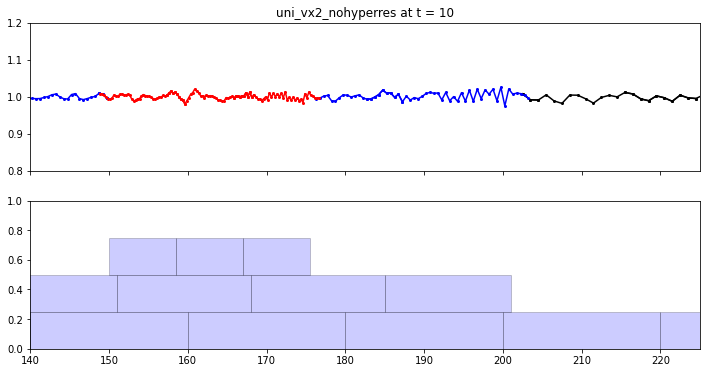

In [42]:
plot_job("uni_vx2_nohyperres", 10, "By", ylim=(0.8,1.2),xlim=(140,225))

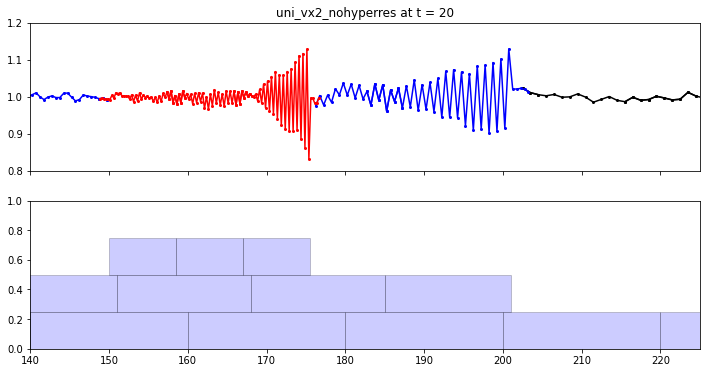

In [41]:
plot_job("uni_vx2_nohyperres", 20, "By", ylim=(0.8,1.2),xlim=(140,225))

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_jobs("uni_vx2_nohyperres", t, "By", it, ylim=(0.8,1.2), xlim=(140,225))

### $\nu = 0$ and $V_x=2$ and no refinement

No specifc issue is seen after T = $20\Omega_{ci}^{-1}$. This confirms the issue seen in the refined case is due to level boundaries and not patch boundaries.

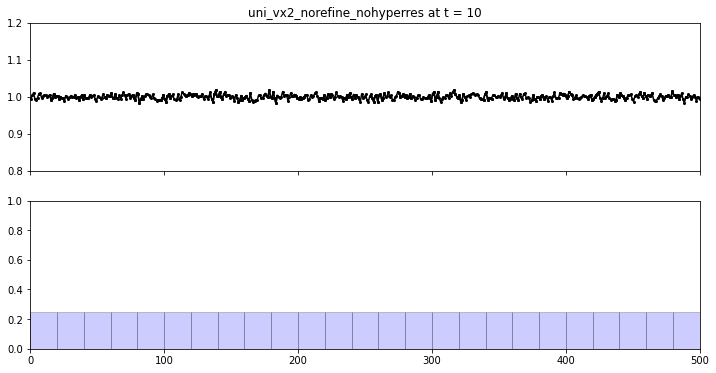

In [125]:
plot_job("uni_vx2_norefine_nohyperres", 10, "By", ylim=(0.8,1.2),xlim=(0,500))

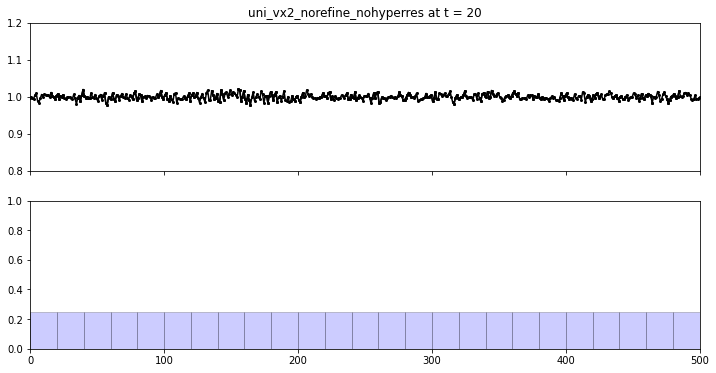

In [126]:
plot_job("uni_vx2_norefine_nohyperres", 20, "By", ylim=(0.8,1.2),xlim=(0,500))

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("uni_vx2_norefine_nohyperres", t, "By", it, ylim=(0.8,1.2), xlim=(0,500))

### $\nu = 0.01$, $V_x=2$, with refinement

One idea is that for a plasma at rest, there are as many waves going leftward and rightward, which causes no specific issue at level boundaries (see the **static tangential discontinuity test**). On the other hand, with a net rightward flow, wave are globally convected rightward.

Since there is a factor 2 refinement ratio between levels, all waves propagating on $L_i$ can propagate on the next coarser level $L_{i-1}$ BUT the waves at $\lambda = 2\Delta x_i = \Delta x_{i-1}$. These smallest wavelength waves on $L_i$ are convected to the downstream boundary but cannot cross it. The flow continuously brings energy at this wavelength at the $L_i$ border, even if this is not much per time unit, it starts to pile-up. The pile-up propagates upstream (leftward) while growing at the boundary, eventually leading to a crash. 

One idea is to kill these wave in the egg, i.e. not allowing them to exist long enough to pile-up. This could be done by applying a well chosen wide band low pass filter that would remove the $2\Delta x_i$ part of the signal, and that is probably the cleaner approach since this is typically a component of the signal that we do not want anywhere, even well inside domain.

A quick way of testing this idea (while not exactly controlling the scale as well as the filter mentioned above) is to turn on the hyper-resistivity term is Ohm's law : 

\begin{equation}
E_{hr} = -\nu\nabla^2\mathbf{j}
\end{equation}

which has the nice property of dominating over the electron convection electric field at small scale. Such a term would efficiently diffuse signal at small scale and prevent pile up.


In this test we test this idea by setting $\nu = 0.01$ (a rather strong value) everywhere in all patches at all times.


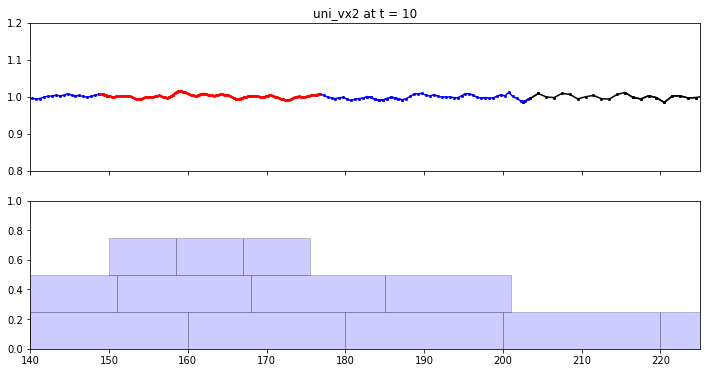

In [128]:
plot_job("uni_vx2", 10, "By", ylim=(0.8,1.2),xlim=(140,225))

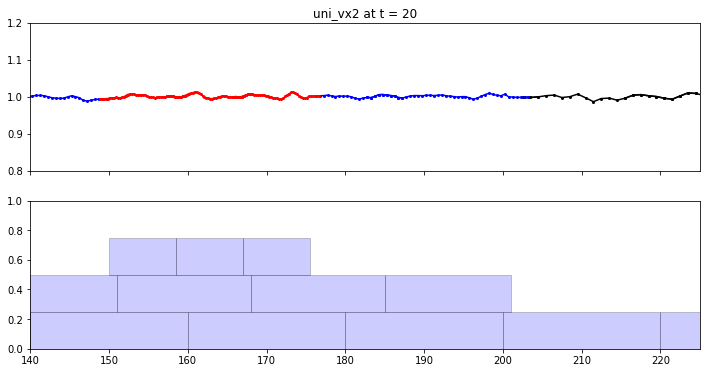

In [124]:
plot_job("uni_vx2", 20, "By", ylim=(0.8,1.2),xlim=(140,225))

At t=10 and t=20 it is clear that no problem is seen at the level boundary as in the non-diffusive run. This indicates that the hyper-resistivity is able to efficiently diffuse away grid-scale waves before they get convected and piled-up at the level boundary.

We still see some occasional minor discontinuity, at the L1-L0 interface that may diserve some further investigation. At this point $\nu$ is constant everywhere and above all it is constant across levels. It would appear better to set a $\nu$ *per level* so that diffusion is fine tuned to be effective the closest to the mesh scale. On the other hand one can also imagine that for a given mesh size the diffusion does not need to be as strong for slower flows, because slower flow means more time to diffuse the same signal.

### $\nu = 0.01$, $V_x=2$, no refinement

This test is not super useful but done anyway.
It illustrates the role of hyper-resistivity rather than anything else.
We can see the magnetic field is a bit smoother than without hyperresistivity, still no issue

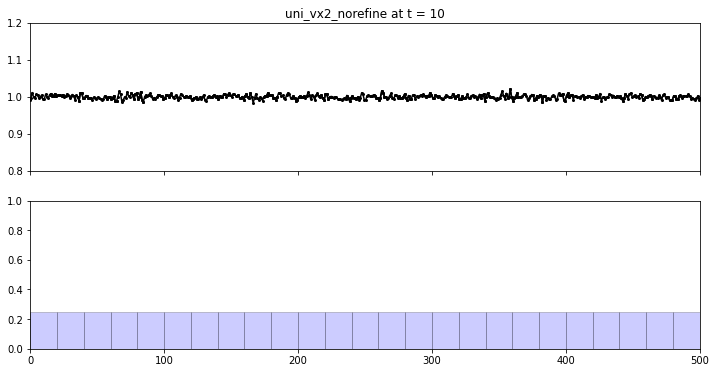

In [62]:
plot_job("uni_vx2_norefine", 10, "By", ylim=(0.8,1.2),xlim=(0,500))

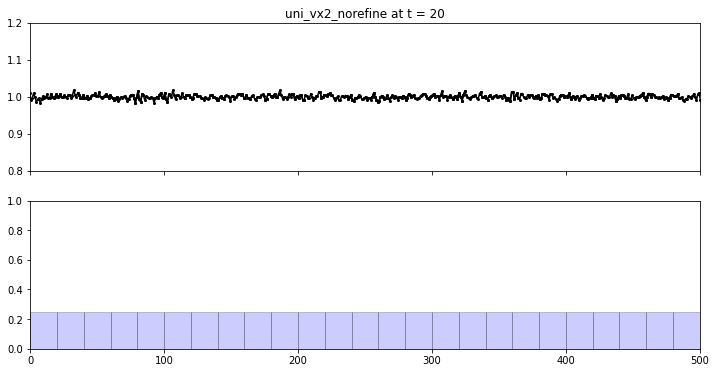

In [63]:
plot_job("uni_vx2_norefine", 20, "By", ylim=(0.8,1.2),xlim=(0,500))

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("uni_vx2_norefine", t, "By", it, ylim=(0.8,1.2), xlim=(0,500))

### $\nu=0.0$ and opposite velocity $V_x=-2$
this test is the same as the uniform refined case done above but this time the velocity is reversed.
The fact that the oscillation appears on the left confirms the issue is the energy pile-up at the downstream level border due to the impossible crossing of grid scale waves

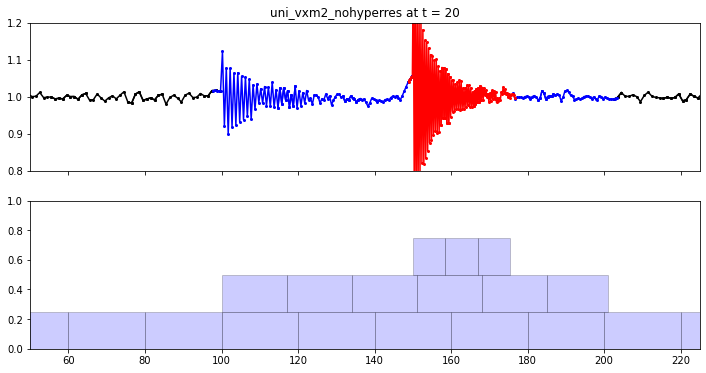

In [33]:
plot_job("uni_vxm2_nohyperres", 20, "By",ylim=(0.8,1.2),xlim=(50,225))

### $\nu=0.01$ and $V_x=-2$

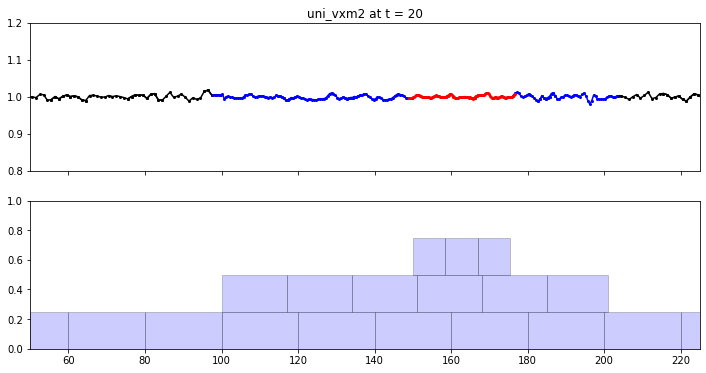

In [35]:
plot_job("uni_vxm2", 20, "By",ylim=(0.8,1.2),xlim=(50,225))

In [64]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("uni_vx2_norefine", t, "By", it, ylim=(0.8,1.2), xlim=(0,500))

## Tangential discontinuity

In this test the initial condition is a tangential discontinuity with $B_y = tanh((y-y_0)/\lambda)$, a constant density $n=1$, $B_z=0.5$ and a pressure balance obtained via the temperature profile. As for the uniform plasma case, we impose a uniform drift velocity $V_x=2$


In [ ]:
# the initialization script
    Simulation(
        smallest_patch_size=20,
        largest_patch_size=20,
        time_step_nbr=2000,        # number of time steps (not specified if time_step and final_time provided)
        final_time=20.,             # simulation final time (not specified if time_step and time_step_nbr provided)
        boundary_types="periodic", # boundary condition, string or tuple, length == len(cell) == len(dl)
        cells=200,                # integer or tuple length == dimension
        dl=1,                  # mesh size of the root level, float or tuple
        refinement_boxes={"L0": {"B0": [(50, ), (150, )]},
                          "L1":{"B0":[(125,),(175,)]}},
        diag_options={"format": "phareh5", "options": {"dir": kwargs["diagdir"],"mode":"overwrite"}}
    )

    def density(x):
        return 1.


    def S(x,x0,l):
        return 0.5*(1+np.tanh((x-x0)/l))


    def bx(x):
        return 0.


    def by(x):
        from pyphare.pharein.global_vars import sim
        L = sim.simulation_domain()[0]
        v1=-1
        v2=1.
        return v1 + (v2-v1)*(S(x,L*0.25,1) -S(x, L*0.75, 1))


    def bz(x):
        return 0.5


    def b2(x):
        return bx(x)**2 + by(x)**2 + bz(x)**2


    def T(x):
        K = 1
        return 1/density(x)*(K - b2(x)*0.5)


    def vx(x):
        return kwargs["vx"]


    def vy(x):
        return 0.


    def vz(x):
        return 0.


    def vthx(x):
        return T(x)


    def vthy(x):
        return T(x)


    def vthz(x):
        return T(x)

###  Without hyper-resistivity

Without hyper-resistivity we observe the same pile-up behavior we had in the homogeneous case. The sharp gradients brought by the hyper-resistivity only make things worse. The grid-scale pile-up occuring at level boundaries leaks to the coarser domain and alters the coarse signal even.

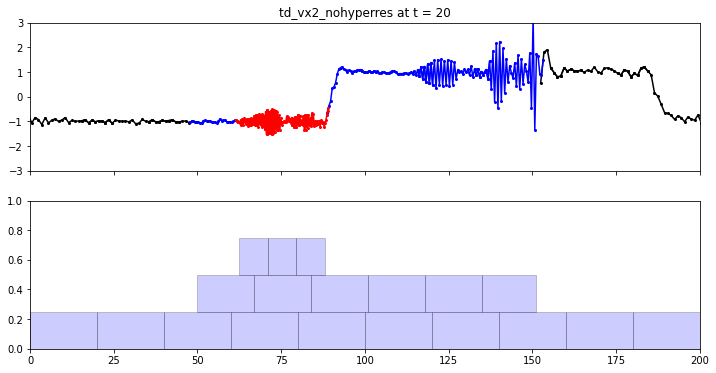

In [52]:
plot_job("td_vx2_nohyperres", 20, "By", ylim=(-3,3),xlim=(0,200))

### $\nu=0$, $V_x=2$ with no refinement

Same non-diffusive run but this time with no refinement. As for the uniform case, we do not have specific issues at patch boundaries indicating the problem really is at level boundaries.
We note some oscillations at the leading and trailing edges of the propagating discontinuities, that are a priori caused by the under resolved sharp gradient.

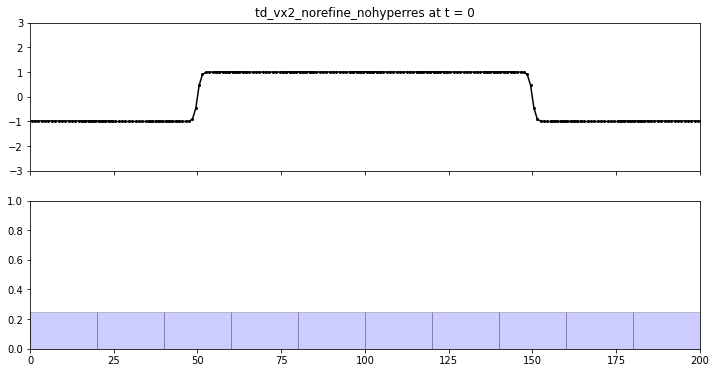

In [72]:
plot_job("td_vx2_norefine_nohyperres", 0, "By", ylim=(-3,3),xlim=(0,200))

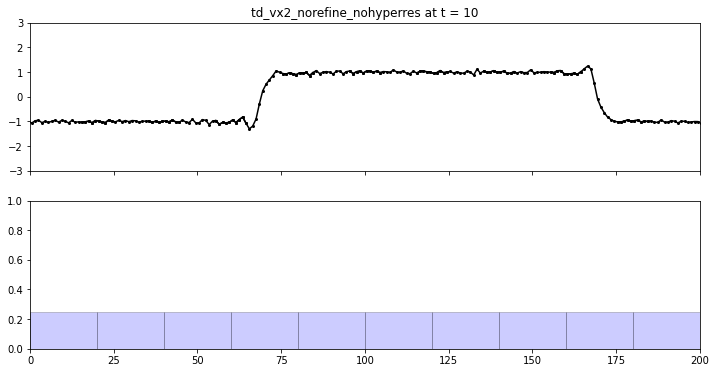

In [72]:
plot_job("td_vx2_norefine_nohyperres", 10, "By", ylim=(-3,3),xlim=(0,200))

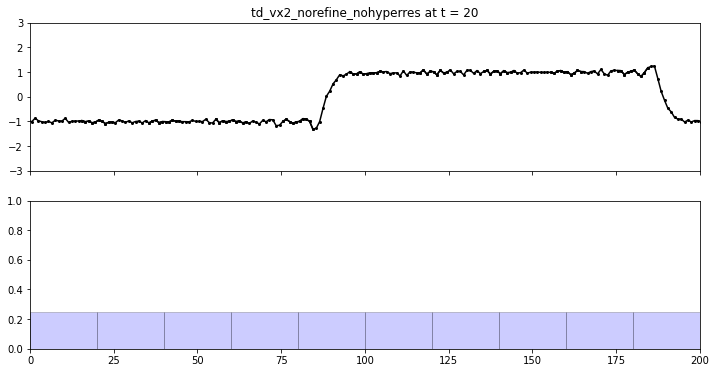

In [73]:
plot_job("td_vx2_norefine_nohyperres", 20, "By", ylim=(-3,3),xlim=(0,200))

###  $\nu = 0.01$, $V_x=2$ with refinement

This run turns on hyper resistivity on the tangential discontinuity case. We can now see that as for uniform cases, the diffusion is able to get rid of the grid-scale pile up at downstream edges of levels. 

We still see some oscillation at the leading and trailing edges of the discontinuities, but we can notice that they are, for the same times, less pronounced. This is probably a beneficial effect of the mesh refinement in this case. The leading edge of the signal has spent some time in the blue L1 level that has probably helped limiting/delaying the development of the oscillation. The trailing edge has spent all/most of its time in the most refined mesh region and we barely notice any oscillation, if compared to the non refined case.

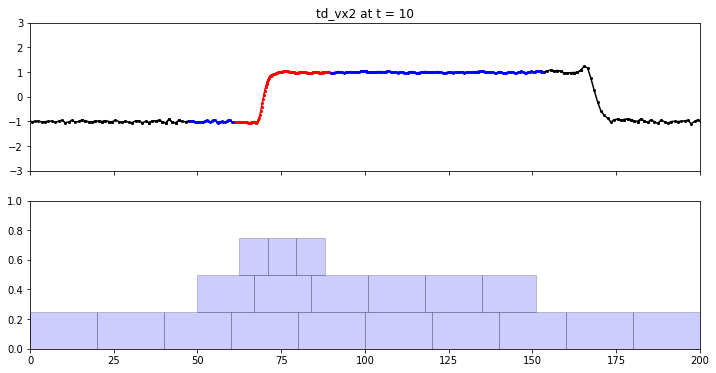

In [70]:
plot_job("td_vx2", 10, "By", ylim=(-3,3),xlim=(0,200))

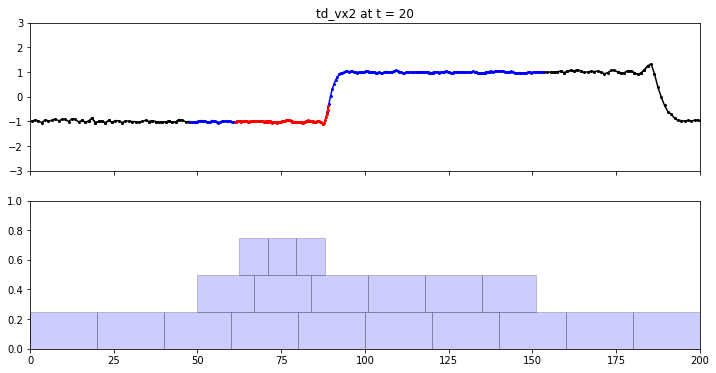

In [47]:
plot_job("td_vx2", 20, "By", ylim=(-3,3),xlim=(0,200))

In [49]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("td_vx2", t, "By", it, ylim=(-3,3), xlim=(0,200))

### $\nu = 0.01$,  $V_x=2$ and no refinement

As for the uniform case this test is not critical and mostly shows the effect of the hyper-resistivity. We see the signal is smoother than in the non-diffusive non refined case as it should. But we also see that the leading/trailing edges oscillations are almost as pronounced. This is because 1/ we do not have refinement, 2/ these oscillations are at a scale that is too large for hyper-resistivity to be efficient. They would probably be diffused by classical Joule diffusion $E_j = \eta\mathbf{j}$ 

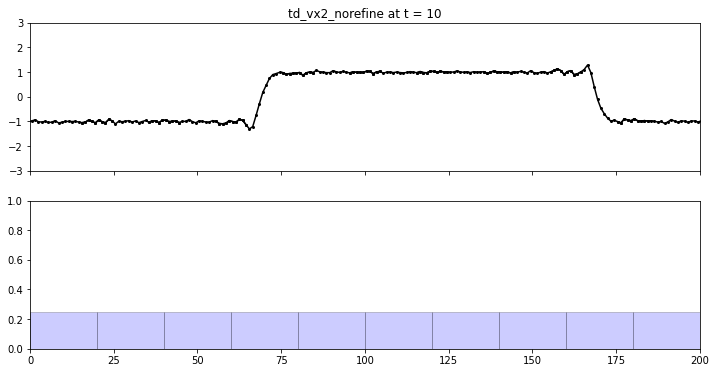

In [67]:
plot_job("td_vx2_norefine", 10, "By", ylim=(-3,3),xlim=(0,200))

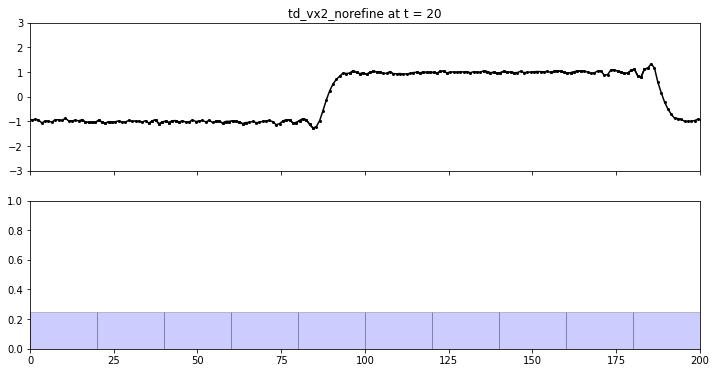

In [68]:
plot_job("td_vx2_norefine", 20, "By", ylim=(-3,3),xlim=(0,200))

In [69]:
#movie
for it,t in enumerate(np.arange(0.,20,0.1)):
    plot_job("td_vx2_norefine", t, "By", it, ylim=(-3,3), xlim=(0,200))

# Static tangential discontinuity test

The goal of this test is to inspect how a simple tangential discontinuity is handle.
In this test we have the following initialization script

In [ ]:
# initialization script
Simulation(
    smallest_patch_size=20,
    largest_patch_size=20,
    time_step_nbr=2000,        # number of time steps (not specified if time_step and final_time provided)
    final_time=20.,             # simulation final time (not specified if time_step and time_step_nbr provided)
    boundary_types="periodic", # boundary condition, string or tuple, length == len(cell) == len(dl)
    cells=500,                # integer or tuple length == dimension
    dl=1.,                  # mesh size of the root level, float or tuple
    refinement_boxes={"L0": {"B0": [(80, ), (180, )]},
                      "L1":{"B0":[(200,),(300,)]}},
    diag_options={"format": "phareh5", "options": {"dir": "td_noflow","mode":"overwrite"}}
)


def density(x):
    return 1.


def S(x,x0,l):
    return 0.5*(1+np.tanh((x-x0)/l))


def bx(x):
    return 0.


def by(x):
    from pyphare.pharein.global_vars import sim
    L = sim.simulation_domain()[0]
    v1=-1
    v2=1.
    return v1 + (v2-v1)*(S(x,L*0.25,1) -S(x, L*0.75, 1))


def bz(x):
    return 0.5


def b2(x):
    return bx(x)**2 + by(x)**2 + bz(x)**2


def T(x):
    K = 1
    return 1/density(x)*(K - b2(x)*0.5)


def vx(x):
    return 0.


def vy(x):
    return 0.


def vz(x):
    return 0.


def vthx(x):
    return T(x)


def vthy(x):
    return T(x)


def vthz(x):
    return T(x)


vvv = {
    "vbulkx": vx, "vbulky": vy, "vbulkz": vz,
    "vthx": vthx, "vthy": vthy, "vthz": vthz
}

MaxwellianFluidModel(
    bx=bx, by=by, bz=bz,
    protons={"charge": 1, "density": density, **vvv, "init": {"seed": 1337}}
)

ElectronModel(closure="isothermal", Te=0.12)

In [1]:
# some variable definitions
main_jobs_path = "../phare_jobs/tests/functional/td/"

jobs = [
        "td_noflow"
      ]

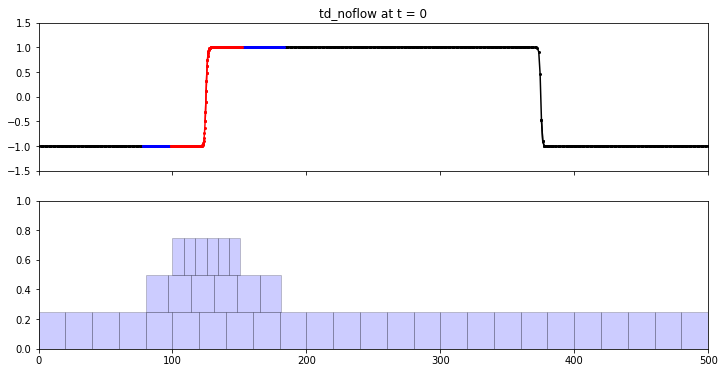

In [11]:
plot_job("td_noflow", 0, "By", ylim=(-1.5,1.5), xlim=(0,500))

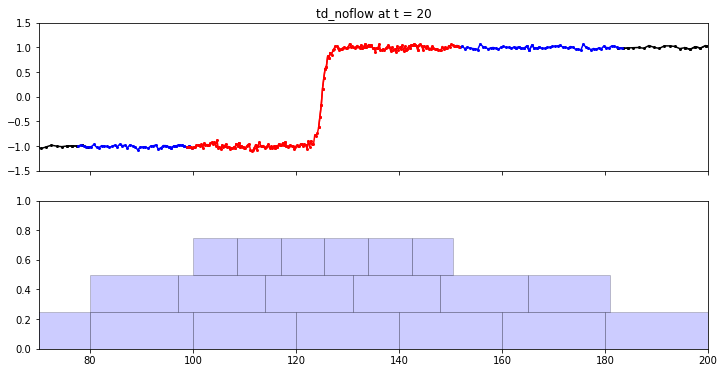

In [16]:
plot_job("td_noflow", 20, "By", ylim=(-1.5,1.5), xlim=(70,200))

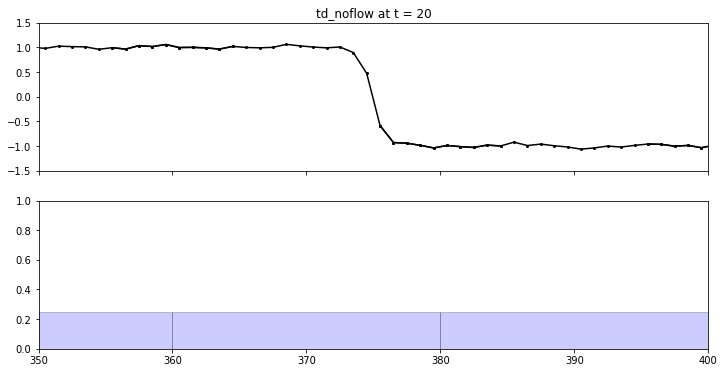

In [18]:
plot_job("td_noflow", 20, "By", ylim=(-1.5,1.5), xlim=(350,400))

In [20]:
#movie
for it,t in enumerate(sorted(get_times(main_jobs_path+"td_noflow/EM_B.h5")[::10])):
    plot_job("td_noflow", t, "By", it, ylim=(-1.5,1.5), xlim=(70,200))

In [21]:
#movie
for it,t in enumerate(sorted(get_times(main_jobs_path+"td_noflow/EM_B.h5")[::10])):
    plot_job("td_noflow", t, "By", it, ylim=(-1.5,1.5), xlim=(350,400))

# Comparaison with Heckle

In [7]:
sys.path.append("/home/aunai/")
main_jobs_path = "../phare_jobs/tests/functional/translation/"

In [8]:
import pywi.runs.heckle as heckle

In [30]:
r = heckle.Heckle("/home/aunai/phare_jobs/heckle_ref/td/")

In [31]:
B0 = r.GetB(0)
B20 = r.GetB(20)
x = r.GetCoords(axis=0)

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


### Heckle VS PHARE without refinement

In this test we initialize both heckle and PHARE with a tangential discontinuity in a global flow $V_x=2$. PHARE is used without refinement so the comparison is just about the numerical properties of the codes and the fact that PHARE uses patches.

<IPython.core.display.Javascript object>


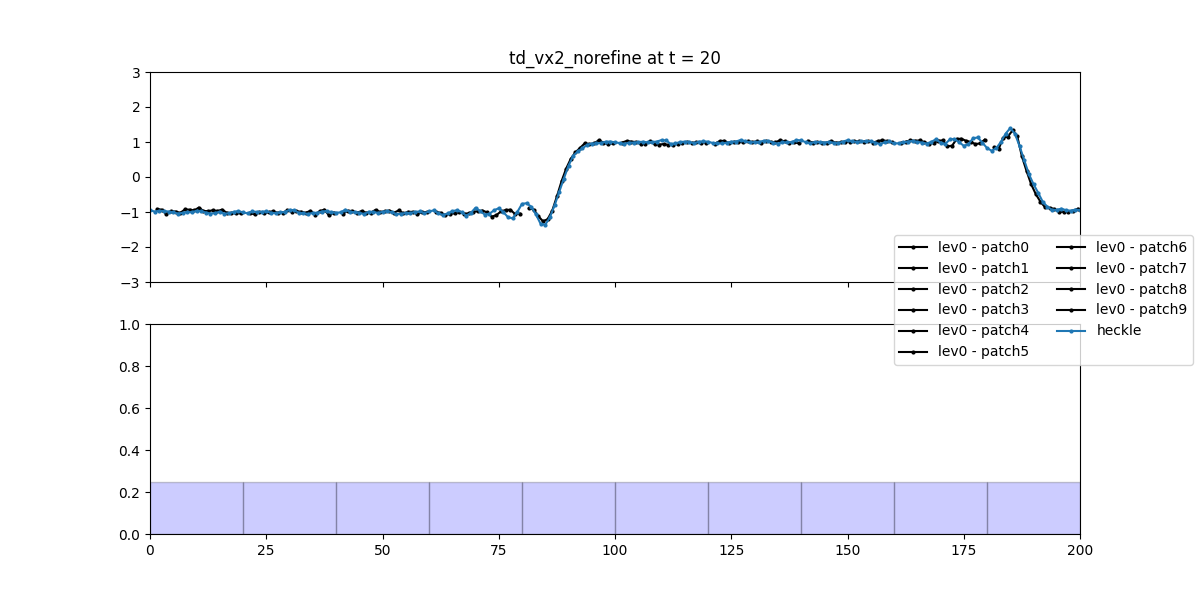

In [36]:
fig,ax1,ax2 = plot_job("td_vx2_norefine", 20, "By", ylim=(-3,3),xlim=(0,200))
ax1.plot(x, B20[:,1], label = "heckle", marker="o", markersize=2)
fig.legend(ncol=2, loc="right")

### Heckle VS PHARE with 3 fixed refinement levels

This is the same test as just above but this time with fixed mesh refinement. We can see that not only PHARE and Heckle give the same evolution down to small oscilations at the leading and trailing discontinuities. This run also confirms the benefit of having mesh refinement by comparing the trailing discontinuity refined in PHARE and not refined in Heckle.

<IPython.core.display.Javascript object>


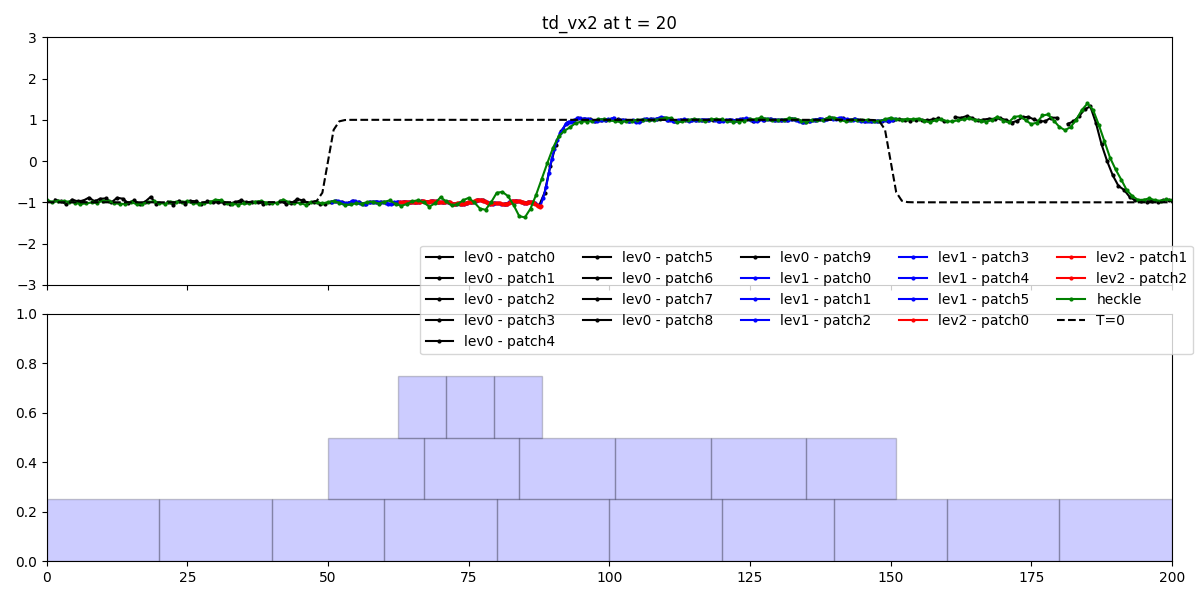

In [39]:
fig,ax1,ax2 = plot_job("td_vx2", 20, "By", ylim=(-3,3),xlim=(0,200))
ax1.plot(x, B20[:,1], label = "heckle", marker="o", markersize=2, color="g")
ax1.plot(x, B0[:,1], label = "T=0",  color="k", ls="--")
fig.legend(ncol=5,loc="center right")
fig.tight_layout()

In [ ]:
for it,t in enumerate(np.arange(0.,20,0.1)):
    fig,ax1,ax2 = plot_job("td_vx2", t, "By", it, ylim=(-3,3),xlim=(0,200))
    ax1.plot(x, r.GetB(t)[:,1], label = "heckle", marker="o", markersize=2, color="g")
    ax1.plot(x, B0[:,1], label = "T=0",  color="k", ls="--")
    fig.legend(ncol=5,loc="center right")
    fig.tight_layout()
    fig.savefig("compare_{:04d}.png".format(it))

In [69]:
B0 = r.GetB(0)
B20 = r.GetB(20)
x = r.GetCoords(axis=0)

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


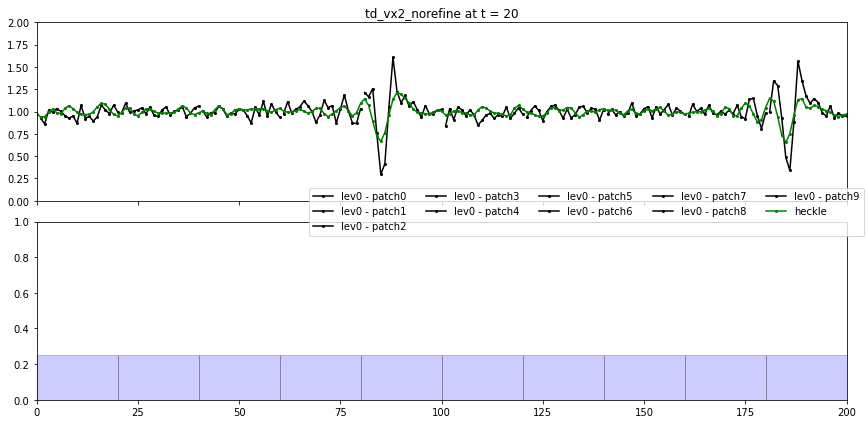

In [168]:
fig, ax1,ax2 = plot_job("td_vx2_norefine", 20, "rho", ylim=(0,2),xlim=(0,200))
ax1.plot(x, r.GetNi(20), marker="o", markersize=2, label="heckle", color="g")
fig.legend(ncol=5,loc="center right")
fig.tight_layout()

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


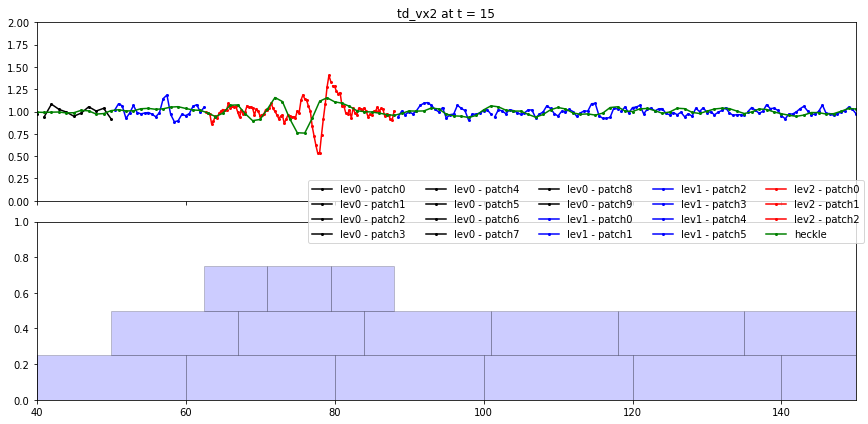

In [176]:
fig, ax1,ax2 = plot_job("td_vx2", 15, "rho", ylim=(0,2),xlim=(40,150))
ax1.plot(x, r.GetNi(15), marker="o", markersize=2, label="heckle", color="g")
fig.legend(ncol=5,loc="center right")
fig.tight_layout()

### Shock wave without refinement

In this test we initialize both Heckle and PHARE with a uniform ($n=1$) density, uniform ($T=.01$) temperature, and a jump from 0.125 to 4 in the magnetic field component $B_y$. This sudden jump in the magnetic pressure should push the plasma outward and lead to the formation of a perpendicular shock wave .

The goal of this test is to see to what extent the solution is the same in heckle and PHARE

In [28]:
r = heckle.Heckle("/home/aunai/phare_jobs/heckle_ref/shock/")
main_jobs_path = "../phare_jobs/tests/functional/shock/"

<IPython.core.display.Javascript object>


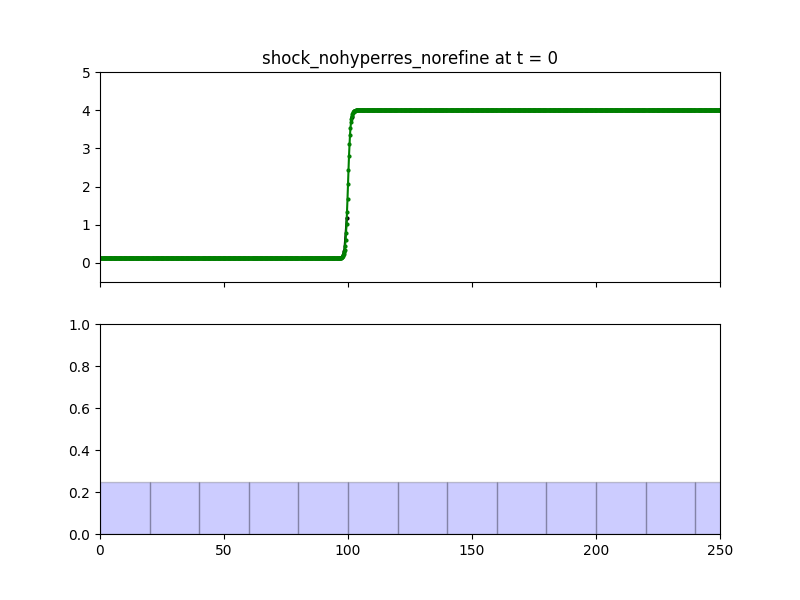

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


In [31]:
fig,ax1, ax2 = plot_job("shock_nohyperres_norefine", 0, "By", ylim=(-0.5,5), xlim=(0,250))
ax1.plot(r.GetCoords(axis=0), r.GetB(0)[:,1], marker='o', markersize=2, color="g")

After some tests it seems $\Delta x = 1$ is unstable with PHARE even with $\nu=0.01$ and decreasing the time step does not help, while Heckle seems ok with it even with $\nu=0.0001$. The difference might lie in the density smoothing Heckle performs after deposit and that PHARE does not do. In the following we therefore use $\Delta x=0.2$ for both heckle and PHARE and obtain the same results. Further investigations could be necessary to see what's the max mesh size we could use and why...

<IPython.core.display.Javascript object>


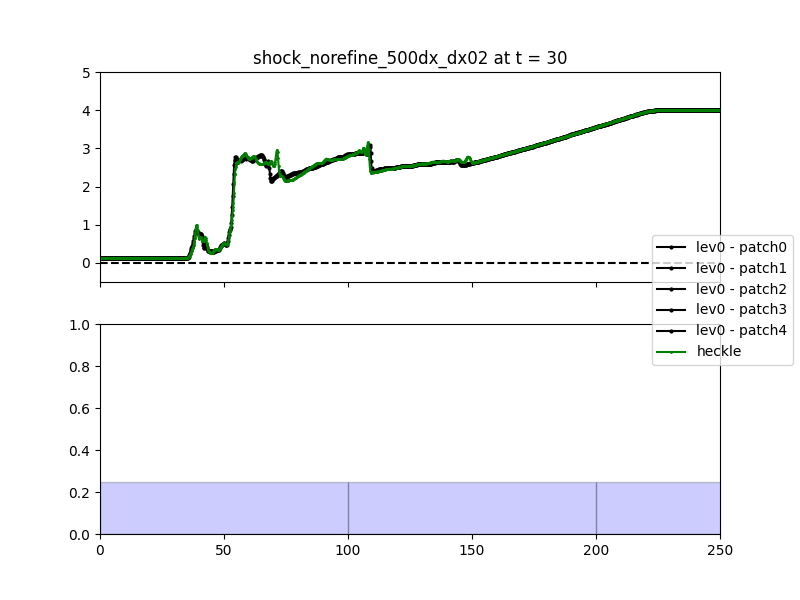

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


In [43]:
fig,ax1, ax2 = plot_job("shock_norefine_500dx_dx02", 30, "By", ylim=(-0.5,5), xlim=(0,250))
ax1.plot(r.GetCoords(axis=0), r.GetB(30)[:,1], marker='o', markersize=1, color="g", label="heckle")
ax1.axhline(ls='--', color='k')
fig.legend(loc="center right")

Below is the same run for heckle but we have changed the smallest patch size in PHARE to be 20 cells. This ensures the solution is independant of the number of patches, and hence patch boundaries are no problem. Note the random seed is different between the two runs of PHARE which may explain the very faint differences, but the solution is very much the same.

<ipython-input-5-f458918e2e73>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,6), sharex=True)


<IPython.core.display.Javascript object>


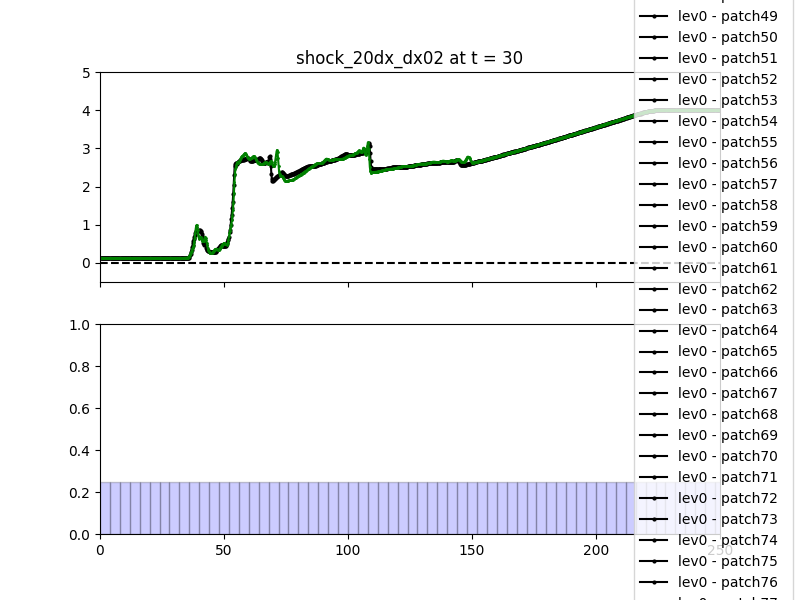

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


In [45]:
fig,ax1, ax2 = plot_job("shock_20dx_dx02", 30, "By", ylim=(-0.5,5), xlim=(0,250))
ax1.plot(r.GetCoords(axis=0), r.GetB(30)[:,1], marker='o', markersize=1, color="g", label="heckle")
ax1.axhline(ls='--', color='k')
fig.legend(loc="center right")

below is the density in both Heckle and PHARE at $T=30$. while globally the same, the main difference probably comes from the smoothing used in Heckle and not in PHARE.

<ipython-input-5-f458918e2e73>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,6), sharex=True)


<IPython.core.display.Javascript object>


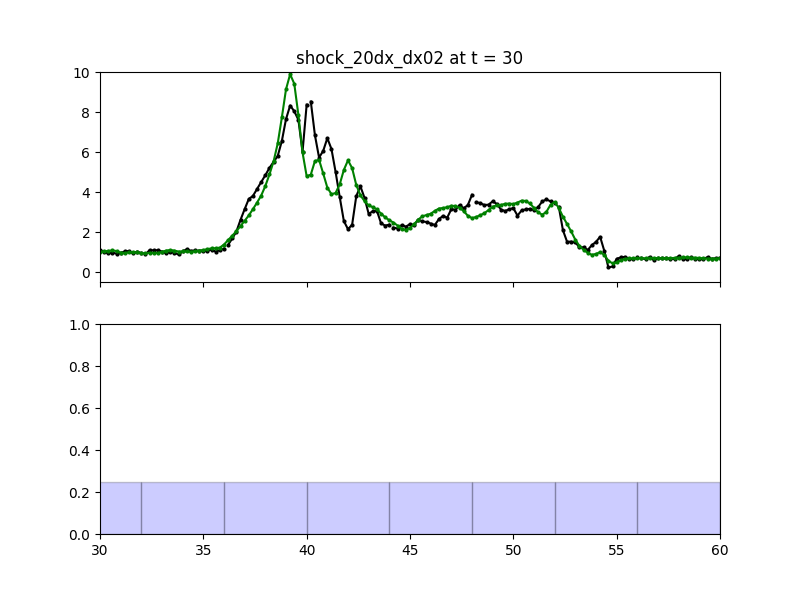

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


In [51]:
fig,ax1, ax2 = plot_job("shock_20dx_dx02", 30, "rho", ylim=(-0.5,10), xlim=(30,60))
ax1.plot(r.GetCoords(axis=0), r.GetNi(30), marker='o', markersize=2, color="g")

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,30,0.1)):
    fig,ax1, ax2 = plot_job("shock_norefine_500dx_dx02", t, "By", ylim=(-0.5,5), xlim=(0,250))
    ax1.plot(r.GetCoords(axis=0), r.GetB(t)[:,1], marker='o', markersize=1, color="g", label="heckle")
    ax1.axhline(ls='--', color='k')
    fig.legend(loc="center right")
    fig.tight_layout()
    fig.savefig("compare_shock_{:04d}.png".format(it))

### Shock wave comparison between Heckle and PHARE with fixed refinement

In this run, Heckle still has a resolution $\Delta x = 0.2$ but the coarsest resolution in PHARE is $\Delta x=0.5$. One can see tthe two codes are ok when the shock wave still propagates in the refined region ($\Delta x=0.25$ or $\Delta x= 0.125$) but quickly deteriorates as it enters in the non refined region.

<IPython.core.display.Javascript object>


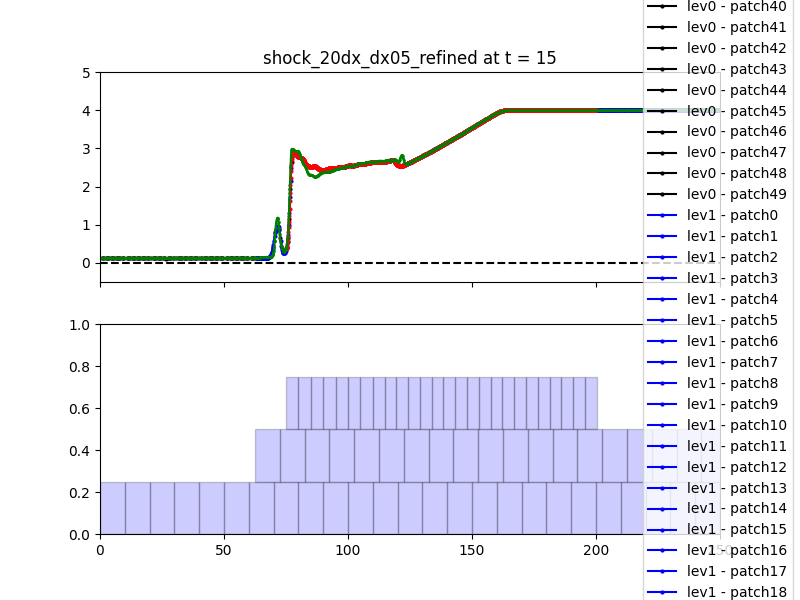

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


In [61]:
fig,ax1, ax2 = plot_job("shock_20dx_dx05_refined", 15, "By", ylim=(-0.5,5), xlim=(0,250))
ax1.plot(r.GetCoords(axis=0), r.GetB(15)[:,1], marker='o', markersize=1, color="g", label="heckle")
ax1.axhline(ls='--', color='k')
fig.legend(loc="center right")

<IPython.core.display.Javascript object>


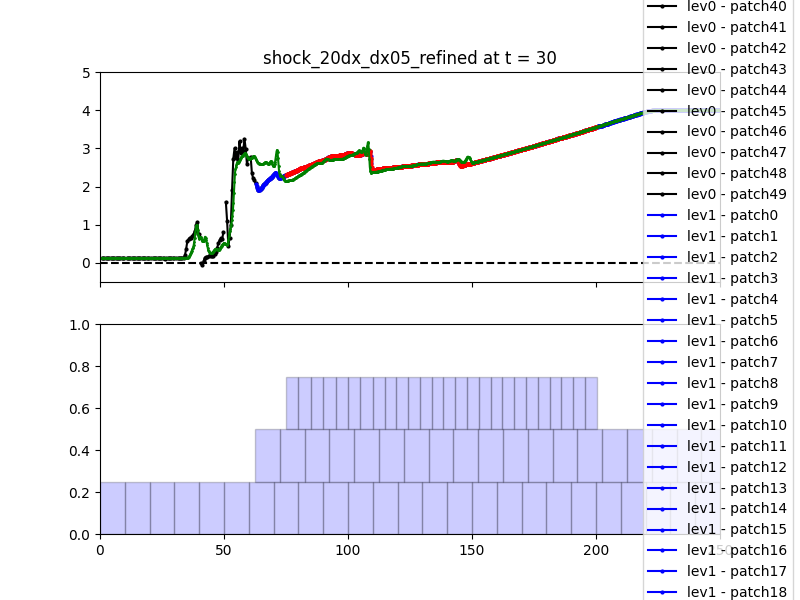

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


In [57]:
fig,ax1, ax2 = plot_job("shock_20dx_dx05_refined", 30, "By", ylim=(-0.5,5), xlim=(0,250))
ax1.plot(r.GetCoords(axis=0), r.GetB(30)[:,1], marker='o', markersize=1, color="g", label="heckle")
ax1.axhline(ls='--', color='k')
fig.legend(loc="center right")

In [ ]:
#movie
for it,t in enumerate(np.arange(0.,30,0.1)):
    fig,ax1, ax2 = plot_job("shock_20dx_dx05_refined", t, "By", ylim=(-0.5,5), xlim=(0,250))
    ax1.plot(r.GetCoords(axis=0), r.GetB(t)[:,1], marker='o', markersize=1, color="g", label="heckle")
    ax1.axhline(ls='--', color='k')
    fig.legend(loc="center right")
    fig.tight_layout()
    fig.savefig("compare_shock_{:04d}.png".format(it))
    plt.close(fig)

In the case below we only add one refined level. L0 now has a $\Delta x=0.2$ and L1 has $\Delta x=0.1$. We see both code show again the same features at T=30.

<IPython.core.display.Javascript object>


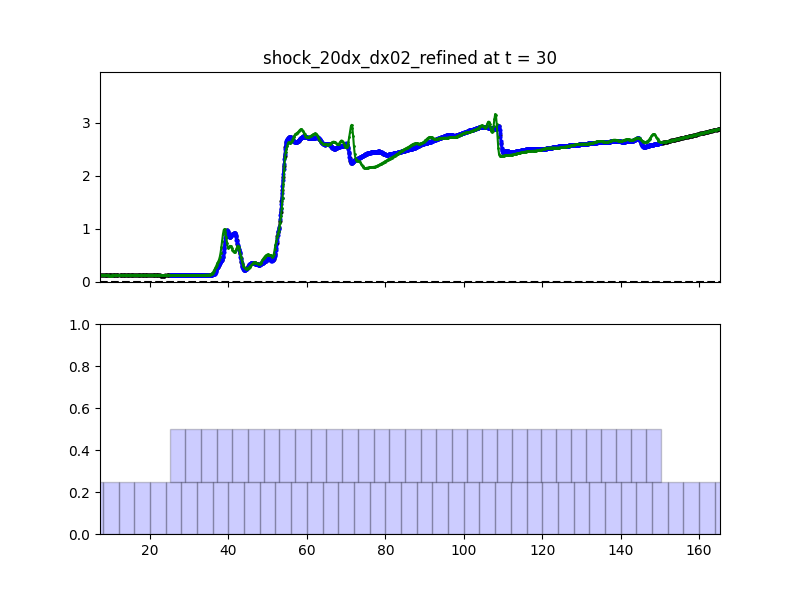

/home/aunai/pywi/runs/heckle.py:158: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  data = f[mygroups+'/'+fieldname].value


In [60]:
fig,ax1, ax2 = plot_job("shock_20dx_dx02_refined", 30, "By", ylim=(-0.5,5), xlim=(0,500))
ax1.plot(r.GetCoords(axis=0), r.GetB(30)[:,1], marker='o', markersize=1, color="g", label="heckle")
ax1.axhline(ls='--', color='k')
#fig.legend(loc="center right")